# The Mathematics of Trade Wars: Stock-Flow Consistent (SFC) Modeling

**Based on the work of Michael Pettis, Matthew Klein, and Joan Robinson.**

This notebook moves beyond historical data visualization to **theoretical simulation**. We will use Stock-Flow Consistent (SFC) models to demonstrate why the current global arrangement of persistent trade imbalances is mathematically unsustainable.

## The Core Theory

### 1. The Accounting Identity
$$ CA = S - I $$
A Current Account Surplus ($CA > 0$) effectively means a country is saving more than it invests ($S > I$). It must export this excess capital abroad.

### 2. The Global Constraint
The world is a closed economy. The sum of all Current Account balances must equal zero.
$$ \sum CA_{world} = 0 $$
Therefore, if Country A runs a structural surplus (via "Beggar-thy-neighbour" policies), Country B **must** run a deficit.

### 3. The Debt Trap (Stock-Flow Consistency)
Mainstream economics often focuses on flows (GDP, Annual Trade Deficit). SFC models focus on **Stocks** (Debt, Net Wealth) **as well as Flows**, ensuring they mathematically integrate.

If the interest rate on debt ($r$) is higher than the economic growth rate ($g$), a debtor nation ($CA < 0$) will see its debt-to-GDP ratio explode exponentially, even if it stops buying foreign goods. This is the **"Snowball Effect."**

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set visual style
sns.set_theme(style="whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Limitations & Theoretical Assumptions

Before running the models, it is important to address what this model includes and excludes, particularly regarding **Money Creation** and **Exchange Rates**.

### 1. Why no "Money Printing"?
In international accounting, printing money (expanding the central bank balance sheet) does not erase external debt. 
* If the US prints dollars to pay for imports, foreign exporters (or their central banks) end up holding those dollars.
* Those dollars represent a claim on the US (a liability). 
* Therefore, printing money changes the **composition** of the Net International Investment Position (NIIP) from bonds to currency, but it does not improve the *Net* position. The country remains a debtor.

### 2. Why no Exchange Rates?
Standard economics assumes that if a country runs a deficit, its currency will depreciate, making its exports cheaper and fixing the imbalance. 
* **The Pettis/Klein Thesis** argues that this mechanism is broken. Surplus nations (like China or Germany) effectively **peg** their currencies or recycle surpluses into deficit assets regardless of price.
* By omitting flexible exchange rates, this model simulates a world where **capital flows drive trade**, and prices are unable to adjust to clear the market—which Pettis argues is exactly the world we live in.

### 3. The Definition of "SFC" here
This is a **Partial SFC Model**. It tracks the consistency of **International** Stocks (Net Foreign Assets) and Flows (Current Account). It does not model domestic sectoral balances (Households vs Firms vs Banks) explicitly, but bundles them into the national aggregate.

## Model 1: The Simplified 2-Bloc Simulation

This model divides the world into two entities:
1.  **The Surplus Bloc (e.g., China, Germany):** Consistently runs a trade surplus (3% of GDP).
2.  **The Deficit Bloc (e.g., USA):** Acts as the consumer of last resort, absorbing the surplus.

**The Goal:** Observe when the cost of servicing debt (Interest Payments) becomes larger than the trade deficit itself.

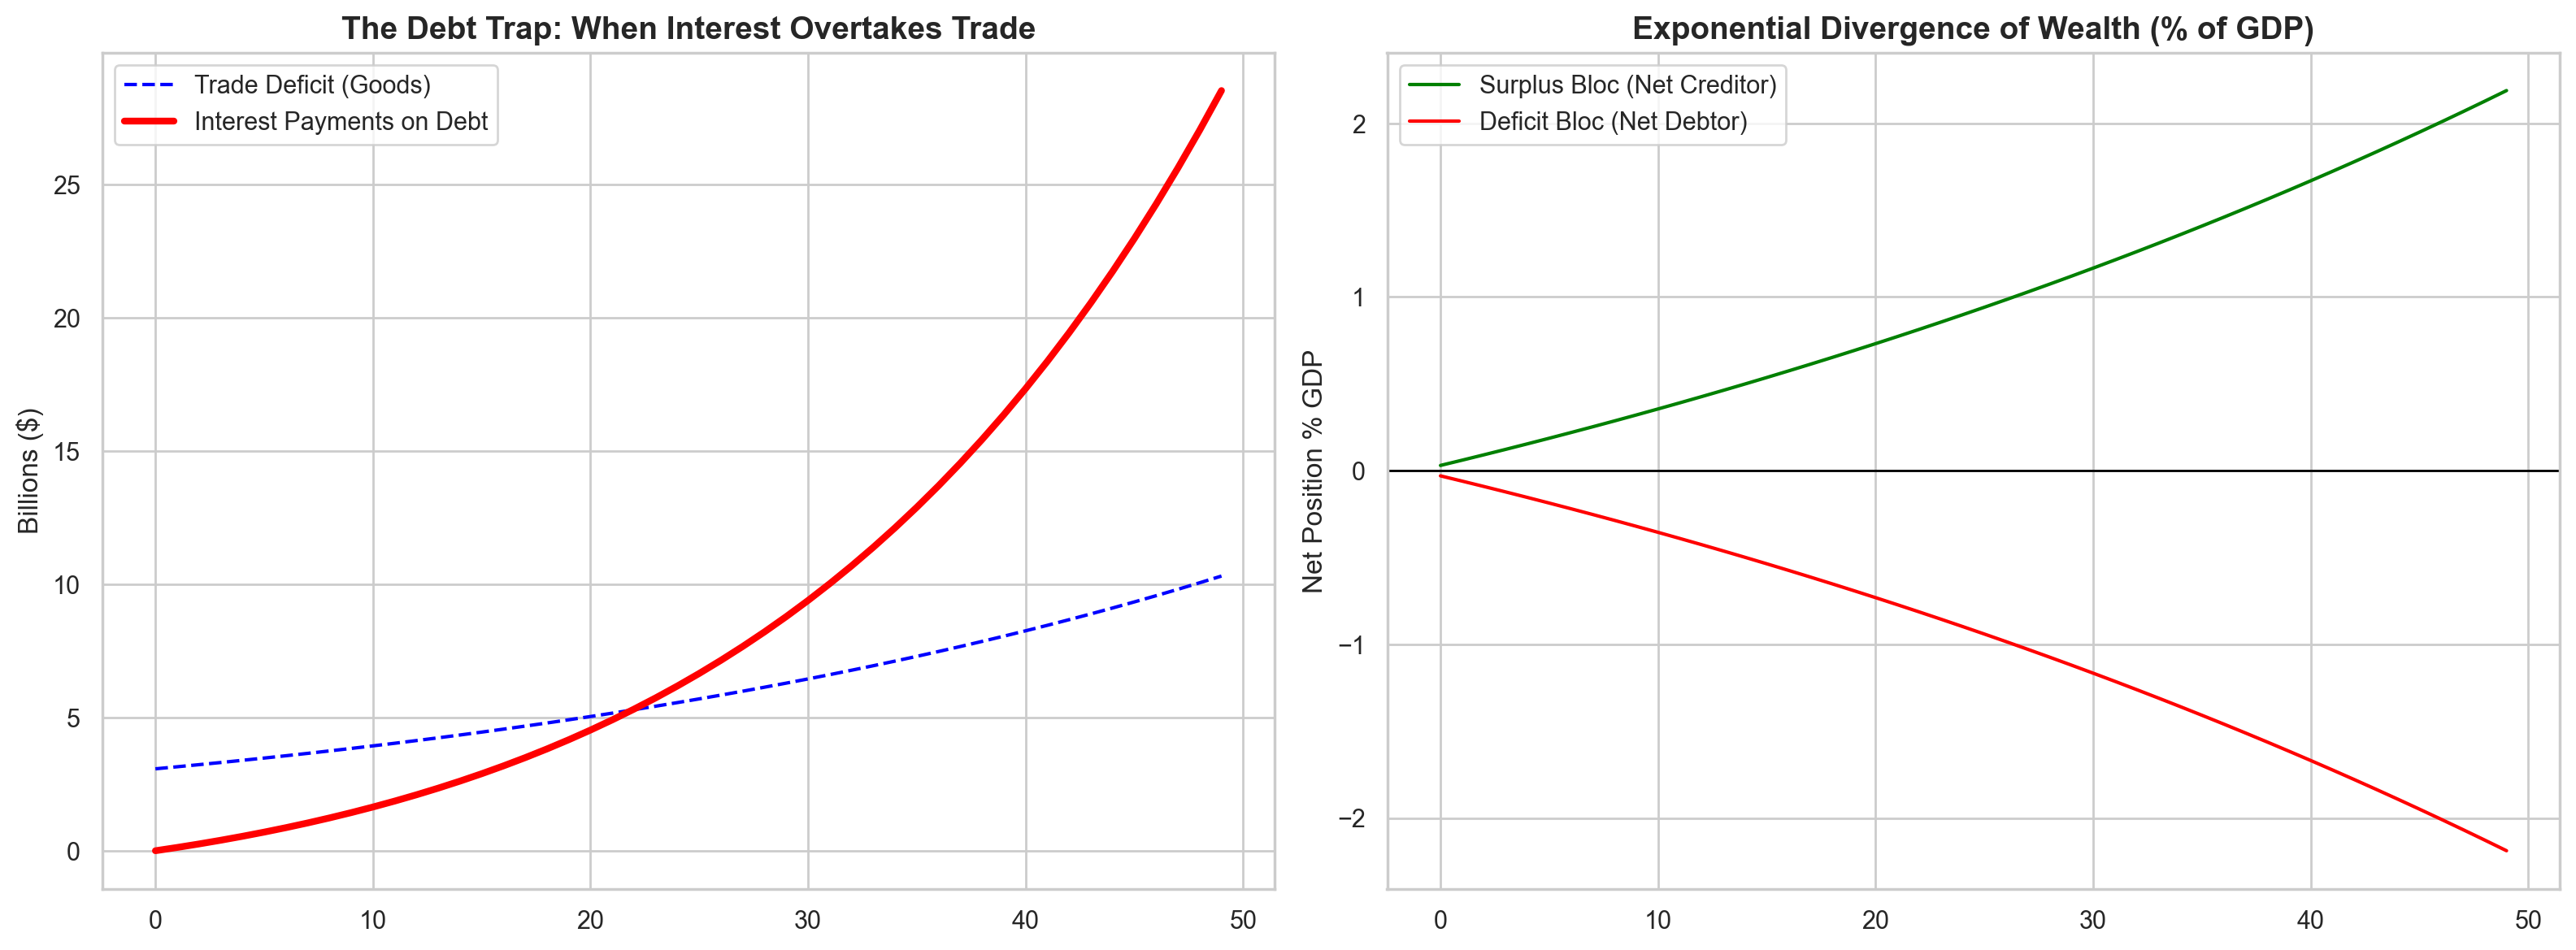

In [8]:
# --- MODEL PARAMETERS ---
YEARS = 50
INITIAL_GDP = 100.0

# Economic Assumptions (The "r > g" trap)
GROWTH_RATE = 0.025      # 2.5% annual GDP growth (g)
INTEREST_RATE = 0.04     # 4.0% average yield on assets/debt (r)

# Policy: Surplus Bloc targets a surplus of 3% of GDP
SURPLUS_TARGET_PCT = 0.03 

class EconomySimple:
    def __init__(self, name, role):
        self.name = name
        self.role = role # 'surplus' or 'deficit'
        self.gdp = INITIAL_GDP
        self.niip = 0.0  # Net International Investment Position
        self.history = []

    def step(self, year, global_imbalance):
        # 1. Grow GDP
        self.gdp = self.gdp * (1 + GROWTH_RATE)
        
        # 2. Determine Trade Flows
        if self.role == 'surplus':
            trade_balance = self.gdp * SURPLUS_TARGET_PCT
        else:
            # Deficit bloc absorbs the surplus bloc's exports
            trade_balance = -global_imbalance
        
        # 3. Calculate Interest Flows (Stock -> Flow)
        # Income earned on assets or paid on liabilities
        net_income_payment = self.niip * INTEREST_RATE
        
        # 4. Current Account = Trade + Income
        current_account = trade_balance + net_income_payment
        
        # 5. Update Stock Position (Flow -> Stock)
        self.niip = self.niip + current_account
        
        # Record Data
        self.history.append({
            'Year': year,
            'GDP': self.gdp,
            'Trade Balance': trade_balance,
            'Net Income (Interest)': net_income_payment,
            'Current Account': current_account,
            'NIIP (Net Wealth)': self.niip,
            'NIIP % GDP': (self.niip / self.gdp)
        })
        
        return trade_balance if self.role == 'surplus' else 0

# --- RUN SIMULATION ---
surplus_bloc = EconomySimple("Surplus Bloc", "surplus")
deficit_bloc = EconomySimple("Deficit Bloc", "deficit")

for t in range(YEARS):
    imbalance = surplus_bloc.step(t, 0) 
    deficit_bloc.step(t, imbalance)

# Process Data
df_def = pd.DataFrame(deficit_bloc.history)
df_sur = pd.DataFrame(surplus_bloc.history)

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: The Interest Trap
ax1.plot(df_def['Year'], df_def['Trade Balance'].abs(), label='Trade Deficit (Goods)', color='blue', linestyle='--')
ax1.plot(df_def['Year'], df_def['Net Income (Interest)'].abs(), label='Interest Payments on Debt', color='red', linewidth=3)
ax1.set_title("The Debt Trap: When Interest Overtakes Trade", fontsize=14, fontweight='bold')
ax1.set_ylabel("Billions ($)")
ax1.legend()

# Chart 2: The Stock Divergence
ax2.plot(df_sur['Year'], df_sur['NIIP % GDP'], label='Surplus Bloc (Net Creditor)', color='green')
ax2.plot(df_def['Year'], df_def['NIIP % GDP'], label='Deficit Bloc (Net Debtor)', color='red')
ax2.axhline(0, color='black', linewidth=1)
ax2.set_title("Exponential Divergence of Wealth (% of GDP)", fontsize=14, fontweight='bold')
ax2.set_ylabel("Net Position % GDP")
ax2.legend()

plt.tight_layout()
plt.show()

### Interpretation of Model 1
Notice the "Crossover Point" in the left chart. After roughly 20 years, the Deficit Bloc is paying more in **interest** to the Surplus Bloc than it is paying for **actual goods**.

This validates Pettis's warning: The US isn't just buying cheap TVs; it is entering a compound interest spiral to sustain the Surplus Bloc's refusal to consume.

## Model 2: The Sophisticated Multi-Country Simulation

Real-world economies are more complex. Growth rates ($g$) differ (China grows faster than Germany), and trade balances vary.

This model simulates:
* **Sources (Surplus):** Germany, Japan, China, Rest of Eurozone.
* **Sinks (Deficit):** USA, UK.
* **Neutral:** India, Rest of World.

We initialize this model with **realistic 2024 estimates** for GDP and Net International Investment Position (NIIP).

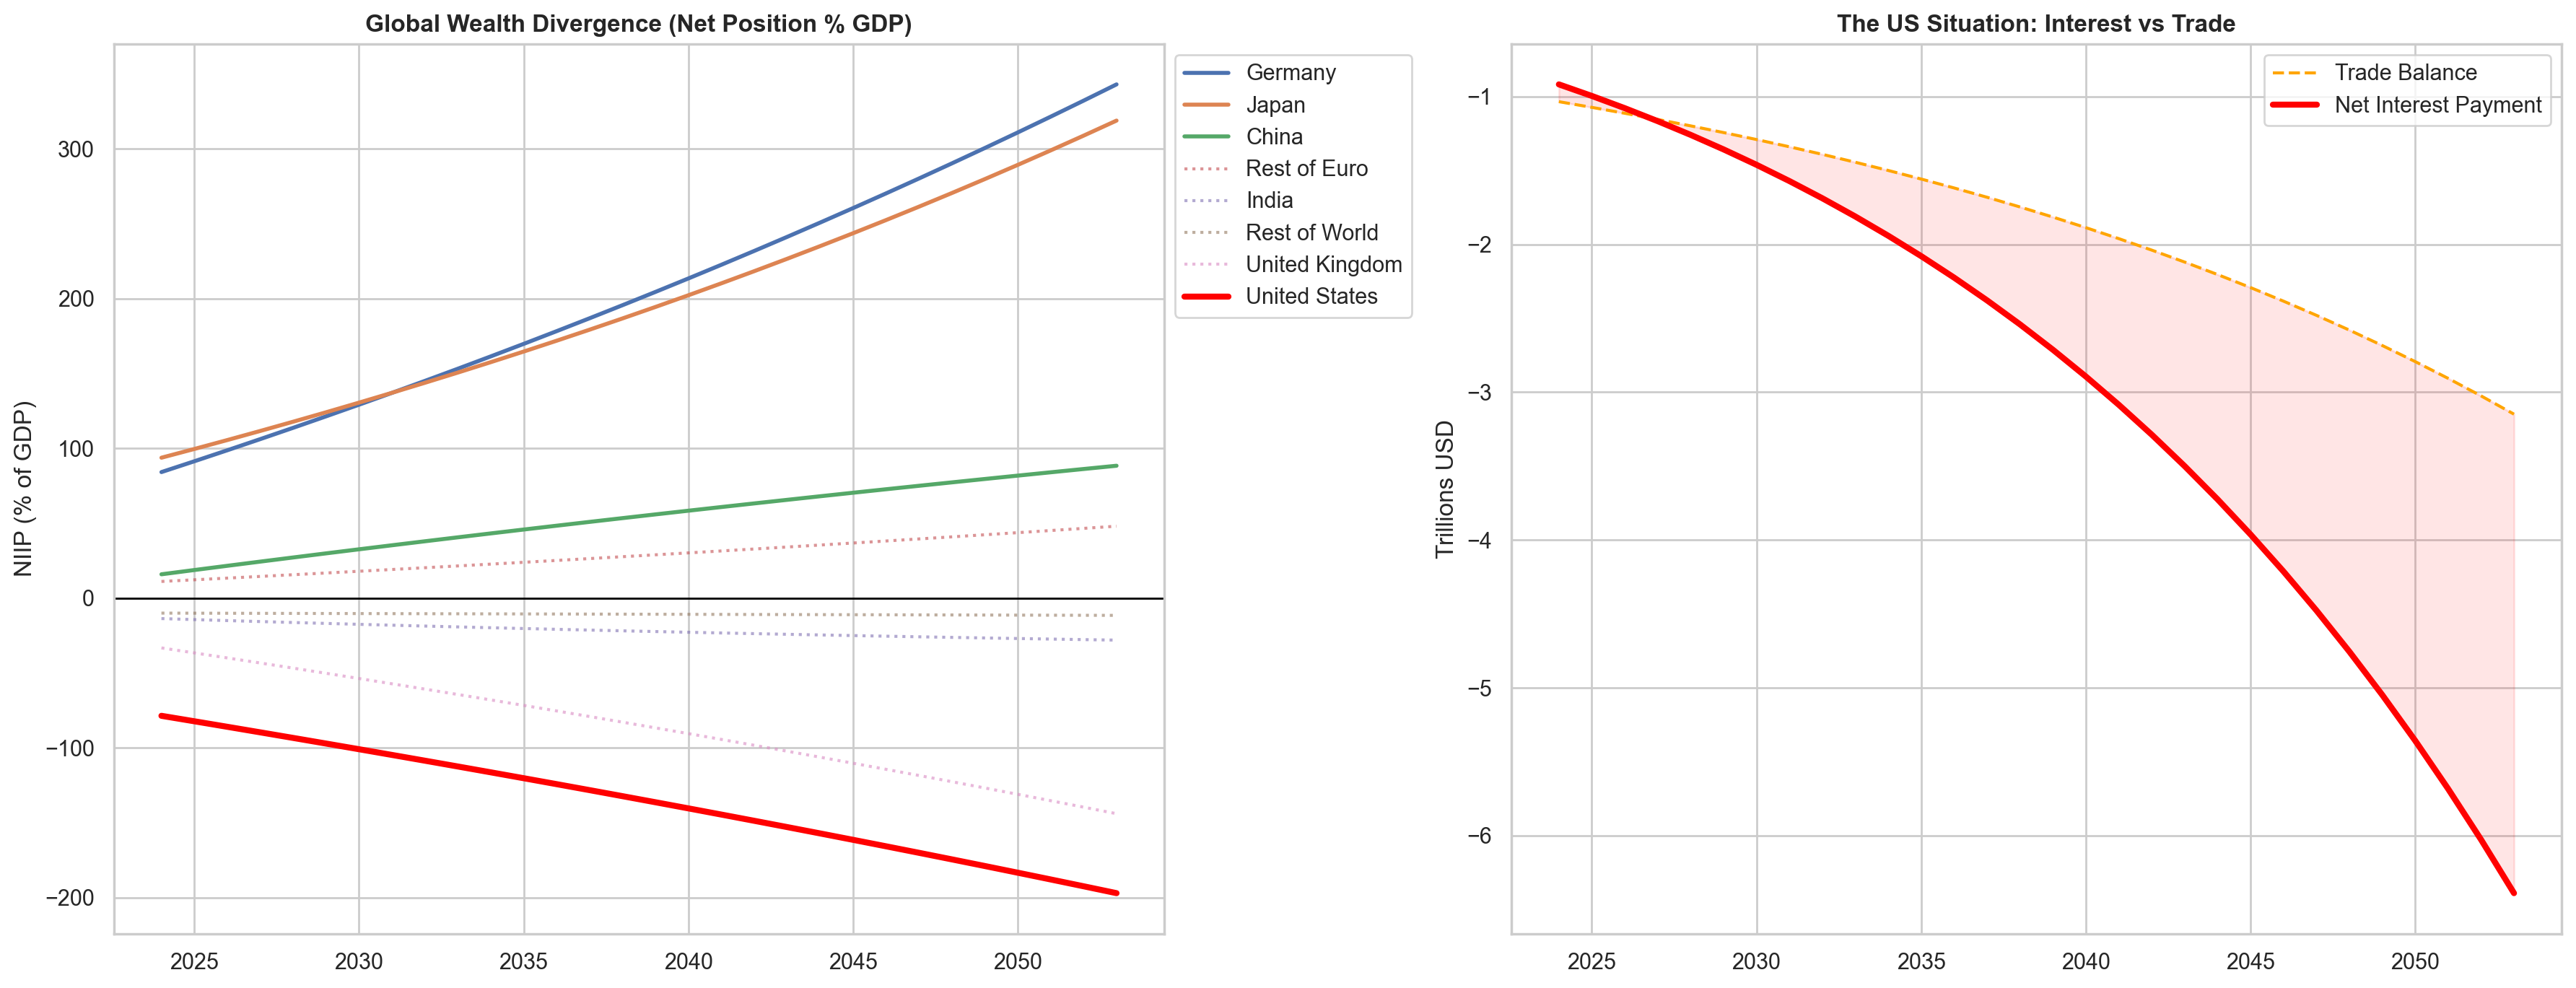

In [9]:
# --- CONFIGURATION (Approximate 2024 Data) ---
START_YEAR = 2024
SIM_YEARS = 30
R_GLOBAL = 0.04  # 4% Yield on global assets

economies_config = [
    # Surplus Nations (The "Push")
    {'name': 'Germany',       'gdp': 5.0,  'g': 0.025, 'target_tb': 0.06,  'niip_gdp': 0.77, 'role': 'source'},
    {'name': 'Japan',         'gdp': 4.3,  'g': 0.020, 'target_tb': 0.04,  'niip_gdp': 0.88, 'role': 'source'},
    {'name': 'China',         'gdp': 19.4, 'g': 0.050, 'target_tb': 0.03,  'niip_gdp': 0.13, 'role': 'source'},
    {'name': 'Rest of Euro',  'gdp': 10.5, 'g': 0.030, 'target_tb': 0.01,  'niip_gdp': 0.10, 'role': 'source'},

    # Neutral / Emerging
    {'name': 'India',         'gdp': 4.1,  'g': 0.065, 'target_tb': -0.01, 'niip_gdp': -0.13, 'role': 'neutral'},
    {'name': 'Rest of World', 'gdp': 35.0, 'g': 0.035, 'target_tb': 0.00,  'niip_gdp': -0.10, 'role': 'neutral'},

    # Deficit Nations (The "Sink")
    {'name': 'United Kingdom','gdp': 4.0,  'g': 0.030, 'target_tb': -0.03, 'niip_gdp': -0.30, 'role': 'sink'},
    # USA acts as the "Swing Producer" of global demand
    {'name': 'United States', 'gdp': 30.6, 'g': 0.035, 'target_tb': None,  'niip_gdp': -0.75, 'role': 'swing'},
]

class EconomyComplex:
    def __init__(self, config):
        self.name = config['name']
        self.gdp = config['gdp'] * 1e12
        self.g = config['g']
        self.target_tb = config['target_tb']
        self.niip = self.gdp * config['niip_gdp']
        self.role = config['role']
        self.history = {'Year': [], 'NIIP % GDP': [], 'Trade Balance': [], 'Interest Payment': []}

    def run_year(self, year, global_surplus_usd=0):
        # 1. Grow Economy
        self.gdp *= (1 + self.g)
        
        # 2. Determine Trade Balance
        if self.role == 'swing':
            # The US absorbs whatever surplus the rest of the world creates
            tb_usd = -global_surplus_usd
        else:
            tb_usd = self.gdp * self.target_tb

        # 3. Calculate Interest (The Snowball)
        interest_usd = self.niip * R_GLOBAL
        
        # 4. Update Wealth Stock
        current_account = tb_usd + interest_usd
        self.niip += current_account
        
        # Record
        self.history['Year'].append(year)
        self.history['NIIP % GDP'].append(self.niip / self.gdp)
        self.history['Trade Balance'].append(tb_usd)
        self.history['Interest Payment'].append(interest_usd)
        
        return tb_usd

# --- SIMULATION LOOP ---
countries = [EconomyComplex(c) for c in economies_config]

for year in range(START_YEAR, START_YEAR + SIM_YEARS):
    # Phase 1: Calculate global surplus generated by non-US countries
    global_surplus = 0
    for c in countries:
        if c.role != 'swing':
            # We assume they hit their trade targets relative to their own GDP
            # (In a simpler model, we calculate this before the full update step)
            global_surplus += (c.gdp * (1+c.g)) * c.target_tb
    
    # Phase 2: Everyone runs the year updates
    for c in countries:
        c.run_year(year, global_surplus)

# --- VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: NIIP Trajectories (Who owns whom?)
for c in countries:
    df = pd.DataFrame(c.history)
    # Highlight key players
    if c.name == 'United States':
        ax1.plot(df['Year'], df['NIIP % GDP']*100, label=c.name, color='red', linewidth=3)
    elif c.name in ['China', 'Germany', 'Japan']:
        ax1.plot(df['Year'], df['NIIP % GDP']*100, label=c.name, linewidth=2)
    else:
        ax1.plot(df['Year'], df['NIIP % GDP']*100, label=c.name, linestyle=':', alpha=0.6)

ax1.axhline(0, color='black', linewidth=1)
ax1.set_title("Global Wealth Divergence (Net Position % GDP)", fontweight='bold')
ax1.set_ylabel("NIIP (% of GDP)")
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot 2: The US Detail
us = next(c for c in countries if c.name == 'United States')
df_us = pd.DataFrame(us.history)
ax2.plot(df_us['Year'], df_us['Trade Balance']/1e12, label='Trade Balance', color='orange', linestyle='--')
ax2.plot(df_us['Year'], df_us['Interest Payment']/1e12, label='Net Interest Payment', color='red', linewidth=3)
ax2.fill_between(df_us['Year'], df_us['Trade Balance']/1e12, df_us['Interest Payment']/1e12, color='red', alpha=0.1)
ax2.set_title("The US Situation: Interest vs Trade", fontweight='bold')
ax2.set_ylabel("Trillions USD")
ax2.legend()

plt.tight_layout()
plt.show()

### Key Takeaways from Model 2

1.  **Stagnation is Dangerous:** Germany and Japan have explosive wealth accumulation (NIIP) largely because their GDP growth ($g$) is low while their trade surplus is high. They are extracting demand from the world faster than they are growing.
2.  **China's Stabilization:** China's NIIP trajectory is flatter because its GDP growth rate ($g=5\%$) is higher than the global interest rate ($r=4\%$). High growth "dilutes" the accumulated wealth stock relative to the size of the economy.
3.  **The US Limit:** The red line in the first chart shows the US Net Position diving toward -100% of GDP and beyond. In reality, a financial crisis or a hard political pivot (Trade War) would occur long before this mathematical limit is reached.